# Using Transfer Learning to Train a CNN

First, we'll import the latest version of PyTorch and prepare to load our training data.

> *Note: The following `pip install` commands install the CPU-based version of PyTorch on Linux, which is appropriate for the Azure Notebooks environment. For instructions on how to install the PyTorch and TorchVision packages on your own system, see https://pytorch.org/get-started/locally/*

In [1]:
# Install PyTorch
#!pip install https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
#!pip install torchvision

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

print("Libraries imported - ready to use PyTorch", torch.__version__)

Libraries imported - ready to use PyTorch 1.3.1


### Load and Prepare the Data

In [2]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    
    # Resize to 256 x 256, center-crop to 224x224 (to match the resnet image size), and convert to Tensor
    transformation = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    # Split into training (70%) and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 32-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=15,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 32-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=15,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


import os 

# The images are in a folder named 'classification/training'
training_folder_name = '../data/classification/training'

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(training_folder_name)
print("Data loaders ready to read", training_folder_name)

['automobile', 'plane', 'train']
Data loaders ready to read ../data/classification/training


### Download a trained model to user as a base

In [3]:
model_resnet = torchvision.models.resnet18(pretrained=True)
for param in model_resnet.parameters():
    param.requires_grad = False

num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, len(classes))

# Now print the full model, which will include the layers of the base model plus the linear layer we added
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Train the Model

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
# Now use the train and test functions to train and test the model    

device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"
print('Training on', device)

# Create an instance of the model class and allocate it to the device
model_resnet = model_resnet.to(device)

# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 3 epochs
epochs = 3
for epoch in range(1, epochs + 1):
        train_loss = train(model_resnet, device, train_loader, optimizer, epoch)
        test_loss = test(model_resnet, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)


Training on cpu
Epoch: 1
	Training batch 1 Loss: 1.356815
	Training batch 2 Loss: 1.209245
	Training batch 3 Loss: 1.196115
	Training batch 4 Loss: 1.344687
	Training batch 5 Loss: 1.182415
	Training batch 6 Loss: 1.272547
	Training batch 7 Loss: 1.215971
	Training batch 8 Loss: 0.943982
	Training batch 9 Loss: 0.901798
	Training batch 10 Loss: 0.902534
	Training batch 11 Loss: 0.922358
	Training batch 12 Loss: 0.842479
Training set: Average loss: 1.107579
Validation set: Average loss: 0.8500, Accuracy: 47/72 (65%)

Epoch: 2
	Training batch 1 Loss: 0.798812
	Training batch 2 Loss: 0.936064
	Training batch 3 Loss: 1.157042
	Training batch 4 Loss: 0.910704
	Training batch 5 Loss: 0.780372
	Training batch 6 Loss: 0.679724
	Training batch 7 Loss: 0.756951
	Training batch 8 Loss: 0.566148
	Training batch 9 Loss: 0.584704
	Training batch 10 Loss: 0.806358
	Training batch 11 Loss: 0.628586
	Training batch 12 Loss: 0.680010
Training set: Average loss: 0.773790
Validation set: Average loss: 0.5

### Using the Trained Model

In [5]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
   
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # These are the classes our model can predict
    class_names = ['automobile', 'plane', 'train']
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the imagees
    image_tensor = torch.stack([transformation(image).float() for image in image_array])

    # Turn the input into a Variable
    input_features = image_tensor

    # Predict the class of each input image
    predictions = classifier(input_features)
    
    predicted_classes = []
    # Convert the predictions to a numpy array 
    for prediction in predictions.data.numpy():
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(class_names[class_idx])
    return np.array(predicted_classes)

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


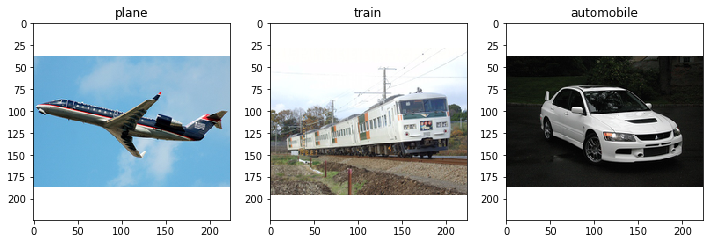

In [6]:
import os
from random import randint
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

model_resnet.to("cpu")

# Get the list of test image files
test_folder = '../data/classification/test'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (224,224)
background_color="white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
                      
    # Add the image to the array of images
    image_arrays.append(resized_img)

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(model_resnet, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])
